In [20]:
import sys
sys.path.append("/home/julius/Projects/system_identification")
from sys_ident.models.monocopter_gruppe_g import MonocopterGruppeG
from sys_ident.models.monocopter import Monocopter
from sys_ident.models.transfer_function_models import SecondOrderContinuousTFModel, FirstOrderContinuousTFModel
from sys_ident.utils import Experiment, SignalHandler, generate_initial_params_lhs
from sys_ident.identifications import GreyBoxIdentification
import numpy as np
import matplotlib.pyplot as plt
from sys_ident.error_assessment import Bootstrap
from copy import deepcopy
from scipy.io import loadmat
from sys_ident.validation import Validation

In [21]:
x_0 = np.array([0., 0.])
params = np.array([1540.0, 2e-2, 6e-3])

In [22]:
# identification_experiment = Experiment(SignalHandler(
#     u_y_w_t_file_names={
#         "u": "u.csv",
#         "w": "",
#         "y": "y.csv",
#         "t": "t.csv",
#     },
#     signals_directory="/home/julius/Projects/system_identification/data",
# ),x_0=x_0)

In [58]:
identification_experiments = []
identfication_mat_files = ["/home/julius/Downloads/Messungen/PRBS30_BB_2.mat", "/home/julius/Downloads/Messungen/PRBS30_BB", "/home/julius/Downloads/Messungen/Training30_2.mat"]
for file in identfication_mat_files:
    identification_data = loadmat(file)
    t = identification_data["data"][0][0][0].flatten()
    y = identification_data["data"][0][0][1][0][0][0].flatten()
    u = identification_data["data"][0][1][1][0][0][0][:,0]
    identification_experiments.append(Experiment(SignalHandler(u_y_w_t=[u, y, None, t]), x_0=x_0))

In [59]:
validation_experiments = []
identfication_mat_files = ["/home/julius/Downloads/Messungen/Val30_BB.mat", "/home/julius/Downloads/Messungen/Sprung30_Tdom_3.mat", "/home/julius/Downloads/Messungen/Training_Sine30_1.mat"]
for file in identfication_mat_files:
    validation_data = loadmat(file)
    t = validation_data["data"][0][0][0].flatten()
    y = validation_data["data"][0][0][1][0][0][0].flatten()
    u = validation_data["data"][0][1][1][0][0][0][:,0]
    validation_experiments.append(Experiment(SignalHandler(u_y_w_t=[u, y, None, t]), x_0=x_0))

In [60]:
experiments = [identification_experiments, validation_experiments]

In [61]:
for experiment in identification_experiments:
    experiment.signal_handler.filter_signals_by_time(200.0, 220.0)

# for experiment in validation_experiments:
#     experiment.signal_handler.filter_signals_by_time(0.0, 750.0)

for experiments_ in experiments:
    for experiment in experiments_:
        experiment.signal_handler.y = (
            (experiment.signal_handler.y / 11.33 - 30.0) * np.pi / 180.0
        )

        experiment.signal_handler.filter_signals_butterworth(6, 0.5)
        experiment.signal_handler.down_sample(50)

        phi_0 = experiment.signal_handler.y_0
        phi_dot_0 = experiment.signal_handler.y_dot_0

        experiment.x_0 = np.array([phi_0, phi_dot_0])

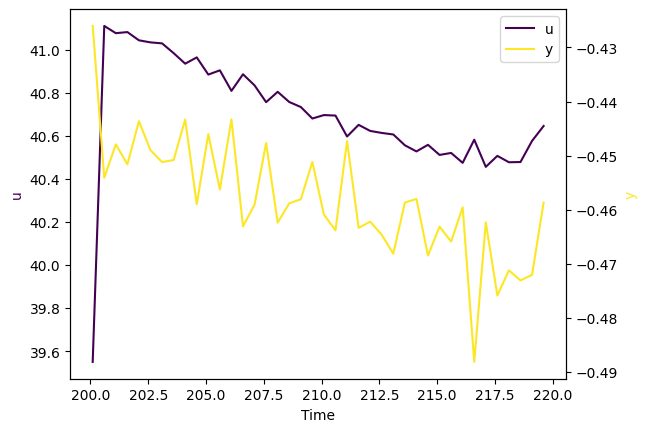

In [27]:
identification_experiments[0].signal_handler.show_signals()

In [28]:
p_start_mono_g = generate_initial_params_lhs(
    num_samples=10,
    p_bounds=np.array([[1000.0, 2000.0], [1e-2, 3e-2], [3e-3, 9e-3]])
)

In [29]:
p_start_mono = generate_initial_params_lhs(
    num_samples=10,
    p_bounds=np.array([[0.0, 100.0], [0.,1800.], [0., 10.]])
)

In [30]:
p_start_tf_second = generate_initial_params_lhs(
    num_samples=10,
    p_bounds=np.array([[-100,100], [-100,100], [-100,100]])
)

In [31]:
p_start_tf_first = generate_initial_params_lhs(
    num_samples=10,
    p_bounds=np.array([[-10,10], [-10,10]])
)

In [32]:
model = MonocopterGruppeG()

In [33]:
identifier = GreyBoxIdentification(
    identification_experiments, model, "MLE", p_start_mono_g, max_iter=50)

In [34]:
theta = identifier.run()

100%|██████████| 10/10 [01:57<00:00, 11.72s/it]


In [35]:
theta

array([1.71515272e+03, 2.20779804e-02, 2.97771613e-03])

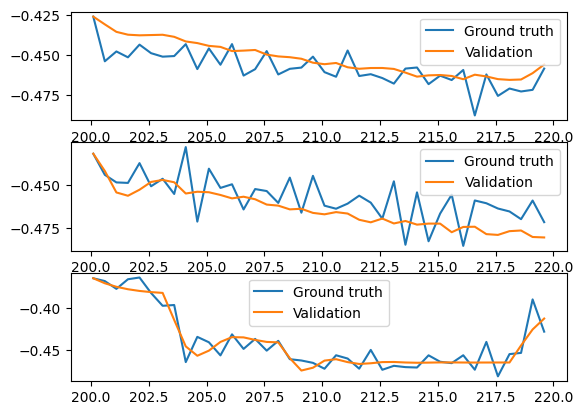

{'fit': 0.607131538819633,
 'AIC': -398.79561957371,
 'AICc': -1178.0535253877968,
 'AIC_norm': -18.483521688570782,
 'BIC': -383.59570448668455}

In [36]:
auto_validation = Validation(identification_experiments, model)
auto_validation.run(["fit", "AIC", "AICc", "AIC_norm", "BIC"], theta)

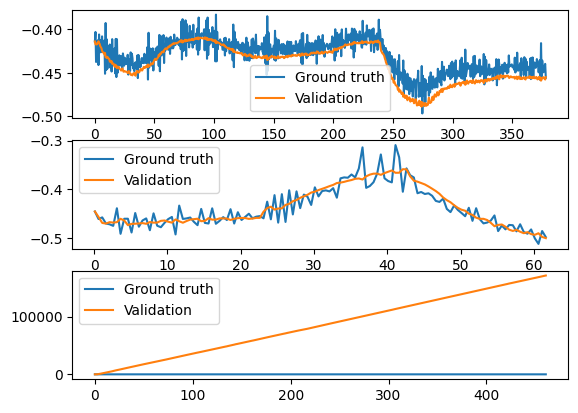

{'fit': -85897.36629989161,
 'AIC': 6079.208281390676,
 'AICc': 18255.66784688883,
 'AIC_norm': -5.832743131949828,
 'BIC': 6116.036851518473}

In [62]:
cross_validation = Validation(validation_experiments, model)
cross_validation.run(["fit", "AIC", "AICc", "AIC_norm", "BIC"],theta)

In [38]:
theta

array([1.71515272e+03, 2.20779804e-02, 2.97771613e-03])